In [400]:
import numpy as np
import math
import cmath
import matplotlib.pyplot as plt
import scipy.special as spl
import scipy.integrate as integrate
import pandas as pd
from numba import jit,njit
import numba as nb
pie=np.pi

In [401]:
pie=np.pi
# Time parameters
h= 0.1 # enter the timestep to be used for simulation
Time_max = 10
Net_time=np.int64(np.floor(Time_max/h)) #
testrange =Net_time


Lambda= 1 #system bath coupling
t_electron=1 #electron bandwidth= = σ
a1=1  #lattice constant
Temp_electron=0.1# electron temperature
Temp_bath= 0.8 #the bath temperature
mu_electron = 0  # chemical potential of the electron
mu_bath = 2.5 #chem potential of the bath



#volume parameters
sitenum = 50 #the no. of sites in the lattice, same as number of momentum modes to be simulated - enter an ODD number
a2=2*pie*(1/(sitenum*a1)) #reciprocal space lattice constant
V_ph = np.arange(-0.5*sitenum*a2,0.5*a2*(sitenum+1),a2)#collect(-0.5*sitenum*a2:a2:0.5*a2*(sitenum+1))


# electron parameters
@njit
def fermi(e,T,mu):
    return 1/(np.exp((e-mu)*(1/T))+1)

@njit
def energy_electron(k):
    return -2*t_electron*(np.cos(V_ph[k]*a1))

@njit
def Gretarded(k,t1,t2):
    return (t1>=t2)*complex(0,-1)*np.exp(complex(0,-1)*energy_electron(k)*(t1-t2)*h)

@njit
def Gkeldysh(k,t1,t2,Telectron,mu):
    return -complex(0,1)*np.tanh((energy_electron(k)-mu)/(2*Telectron))*np.exp(-complex(0,1)*energy_electron(k)*(t1-t2)*h)

#Gkeldysh =lambda k,t1,t2,Telectron,mu: -complex(0,1)*np.tanh((energy_electron(k)-mu)/(2*Telectron))*np.exp(-complex(0,1)*energy_electron(k)*(t1-t2)*h)



#bath parameters
@njit
def J(w,tB):
    return (2/tB)*np.sqrt( 1- (w/(2*tB))**2 )
#J = lambda w,tB: (2/tB)*np.sqrt( 1- (w/(2*tB))**2 )




@njit
def SigmaR(t1,t2,tB):
    if t1>t2:
        sum1= -complex(0,1)*(Lambda**2)*(1)*(1/(tB))*( spl.j1(2*tB*abs(t1-t2)*h) / (abs(t1-t2)*h ) )
        return sum1
    else:
        return 0
@njit
def sigmak(w,tB):
    return -complex(0,1)*(Lambda**2)*J(w,tB)*np.tanh((w-mu_bath)/(2*Temp_bath))
#=lambda w,tB: -complex(0,1)*(Lambda**2)*J(w,tB)*np.tanh((w-mu_bath)/(2*Temp_bath))

@njit
def SigmaK(t1,t2,tB):
    dw=(1/10000)*4*tB
    steps = np.arange(-2*tB,2*tB,dw) #collect(-2*tB:dω:2*tB)
    result=0
    for w in steps:
        result = result + dw*sigmak(w,tB)*np.exp(-complex(0,1)*w*(t1-t2)*h)

    return result/(2*pie)



### spawning Gr & Gk matrices

@njit
def matinit():
    A=[]
    for i in range(len(V_ph)+2):
        A.append( np.zeros((Net_time+5,Net_time+5),dtype=np.complex128))#Array{ComplexF64,2}(undef,Net_time+5,Net_time+5)
        #Gkmatrix.append( np.zeros((Net_time+5,Net_time+5),dtype=np.complex128))
    return A


## Box Initialization ###
boxinitindex=1

@njit
def boxinit_gr(A):

    for k in range(len(V_ph)):
        for i in range(Net_time):
            A[k][i,i] = -complex(0,1) #exactly true           ## Gr(t,t)≂̸0

                ###actual Box Initialization ###

    #GF Initialization

    for k in range(len(V_ph)):
        for i in range(boxinitindex+1):
            for j in range(boxinitindex+1):
                A[k][i,j] = Gretarded(k,i,j)



@njit
def boxinit_gk(A):
    for k in range(len(V_ph)):
        for i in range(boxinitindex+1):
            for j in range(boxinitindex+1):
                A[k][i,j] = Gkeldysh(k,i,j,Temp_electron,mu_electron)


@njit
def clearoff(A):
    r = A.shape[0]
    for i in range(r):
        A[i] = np.zeros((Net_time+5,Net_time+5),dtype=np.complex128)
                    
                
                
                
#matrix definitions

Grmatrix =np.array(matinit())      #  #numba doesn't know what Gr array contains, I use a tuple to get around this
Gkmatrix = np.array(matinit()) #Array{Array{ComplexF64,2},1}(undef,length(V_ph)+2)

SigmaRmatrix = np.zeros(shape=(Net_time+5,Net_time+5),dtype=np.complex128)#Array{ComplexF64,2}(undef,Net_time+5,Net_time+5)
SigmaKmatrix = np.zeros(shape=(Net_time+5,Net_time+5),dtype=np.complex128)#Array{ComplexF64,2}(undef,Net_time+5,Net_time+5)


###
### Code to update the Sigma R, Sigma K matrix
@njit
def sigmaK_init(A,tB):
    # Sigma K matrix setup

    for i in range(testrange):
        A[i,0] = SigmaK(i,0,tB)
        A[0,i] = -np.conj(A[i,0])

    #
    # for i in range(testrange):
    #     A[0,i] = SigmaK(0,i,tB)

    for j in range(testrange):
        for i in range(j,testrange):
            A[i,j] = A[i-j,0]

    for j in range(testrange):
        for i in range(j,testrange):
            A[j,i] = A[0,i-j]


@njit
def sigmaR_init(B,tB):
    # Sigma R matrix setup
    for i in range(testrange):
        B[i,0] =SigmaR(i,0,tB)

    for j in range(testrange):
        for i in range(j,testrange):
            B[i,j] = B[i-j,0]




#### Convolution definitions
@njit
def Sgma_conv_Gr(k,t1,t2):
    sum=0
    if t1>t2:
        sum= SigmaRmatrix[t1,t2]*Grmatrix[k][t2,t2]*(h/2)
        for i in range(t2+1,t1):
            sum = sum + SigmaRmatrix[t1,i]*Grmatrix[k][i,t2]*h
        return sum

    else:
        return 0


Sgma_conv_Gr(2,10,1)

@njit
def Sgma_conv_GK(k,t1,t2):
    sum=0
    if t1>1:
        sum = sum + SigmaRmatrix[t1,1]*Gkmatrix[k][1,t2]*(h/2)

        for i in range(2,t1):               #2:t1-1
            sum = sum+SigmaRmatrix[t1,i]*Gkmatrix[k][i,t2]*h

        return sum

    else:
        return 0



@njit
def Sgma_conv_GA(k,t1,t2):
    if t2>1:
        sum=0
        sum=sum+SigmaKmatrix[t1,1]* np.conjugate(Grmatrix[k][t2,1]) * h*(1/2)  #starting 1/2
        sum=sum+ SigmaKmatrix[t1,t2]* np.conjugate(Grmatrix[k][t2,t2]) * h*(1/2) #ending 1/2

        for i in range(2,t2):# i=2:t2-1:
            sum=sum+ SigmaKmatrix[t1,i]* np.conjugate(Grmatrix[k][t2,i]) * h   #middle ones, they get h & not h/2 due to double addition

        return sum

    else:
        return 0


### Keeping stuff here that helps in plotting the results

energyrange=np.zeros(len(V_ph))
for k in range(len(V_ph)):
    energyrange[k]=energy_electron(k)

@njit
def quadtest(x,en,tB):
    return (1/pie)*(1*fermi(x,Temp_bath,mu_bath))*(Lambda**2)*(J(x,tB))*( 1/( (x-en)**2 + (Lambda**2*J(x,tB))**2 ) )


def newres(e,hop):  # computes n(E) i.e. equilibrium occupation at energy E using bath spectral function
    return integrate.quad(quadtest, -2*hop,2*hop,args=(e,hop))


In [413]:
## code for evolution equations
def evolution(tB,SigmaRmatrix,SigmaKmatrix,Grmatrix,Gkmatrix):
    
    clearoff(Grmatrix)
    clearoff(Gkmatrix)
    boxinit_gr(Grmatrix)
    boxinit_gk(Gkmatrix)
    sigmaK_init(SigmaKmatrix,tB)
    sigmaR_init(SigmaRmatrix,tB)
    
    ###################################### Evolution equations start here #############################

    ####### Gr evolution #########
    
    for i in range(boxinitindex,testrange+1):     ### The diagonal value #should probably start from 2
        # Update GR, GK edges
        for k in range(len(V_ph)):
            for j in range(i+1):
                bessellimit = -complex(0,1)*(Lambda**2)*(1)#*(1)*(1/(tB))*2*tB*(1/2)# *(besselj1(2*tB*abs(t1-t2)*h)/(abs(t1-t2)*h))
                endpoint = (h/2)* Gretarded(k,i+1,i+1)*bessellimit*(h/2)
                endpnt = 1/(1-endpoint)
                Grmatrix[k][i+1,j] = ( complex(0,1)*Gretarded(k,i+1,i)*Grmatrix[k][i,j]+ (h/2)* Gretarded(k,i+1,i)*(Sgma_conv_Gr(k,i,j) + (h/2)*bessellimit*Grmatrix[k][i,j] ) + (h/2)* Gretarded(k,i+1,i+1)*Sgma_conv_Gr(k,i+1,j) )*endpnt





    ######### GK evolution ##############

    for i in range(boxinitindex,testrange+1):     ### The diagonal value #should probably start from 2

        # Update GR, GK edges
        for k in range(len(V_ph)):
            for j in range(i+1):
                bessellimit = -complex(0,1)*(Lambda**2)*(1) #*(1)*(1/(tB))*2*tB*(1/2)# *(besselj1(2*tB*abs(t1-t2)*h)/(abs(t1-t2)*h))
                endpoint = (h/2)* Gretarded(k,i+1,i+1)*bessellimit*(h/2)
                endpnt=1/(1-endpoint)
                Gkmatrix[k][i+1,j] = (complex(0,1)*Gretarded(k,i+1,i)*Gkmatrix[k][i,j]+ (h/2) * Gretarded(k,i+1,i) * ( Sgma_conv_GK(k,i,j)+ h/2*bessellimit*Gkmatrix[k][i,j] + Sgma_conv_GA(k,i,j) )+ (h/2) * Gretarded(k,i+1,i+1) * ( Sgma_conv_GK(k,i+1,j) + Sgma_conv_GA(k,i+1,j) ) )*endpnt
                Gkmatrix[k][j,i+1] = - np.conj(Gkmatrix[k][i+1,j]) # iGᴷ is hermitian  ⟹ iGᴷ(1,2) = conj((iGᴷ(2,1)) ⟹ Gᴷ(1,2) = - conj(Gᴷ(2,1))


        ## Diagonal terms update ##
        #Update GK(t+ϵ,t+ϵ) i.e GK(i+1,i+1) here  - needs Σₑᴿ on the i+1 block edges  i.e.
        for k in range(len(V_ph)):
            bessellimit = -complex(0,1)*(Lambda**2)*(1)#*(1)*(1/(tB))*2*tB*(1/2)# *(besselj1(2*tB*abs(t1-t2)*h)/(abs(t1-t2)*h))
            endpoint = (h/2)* Gretarded(k,i+1,i+1)*bessellimit*(h/2)
            endpnt=1/(1-endpoint)
            Gkmatrix[k][i+1,i+1] = (complex(0,1)*Gretarded(k,i+1,i)*Gkmatrix[k][i,i+1]+ (h/2)*Gretarded(k,i+1,i)*(Sgma_conv_GK(k,i,i+1)+h/2*bessellimit*Gkmatrix[k][i,i+1] + Sgma_conv_GA(k,i,i+1))+ (h/2) * Gretarded(k,i+1,i+1) * ( Sgma_conv_GK(k,i+1,i+1) + Sgma_conv_GA(k,i+1,i+1) ) )*endpnt

    ########################### Evolution equations end here #############################
    return Gkmatrix


In [403]:
jitted_evolution = njit()(evolution)

In [404]:
# ENTER THE LIST OF BATH-BANDWIDTH VALUES HERE
testlist=[31]

In [415]:
# jitted_evolution(bandwidth,SigmaRmatrix,SigmaKmatrix,Grmatrix,Gkmatrix)

In [405]:
%%time 

#### FINAL LOOP THAT RUNS OVER ALL BATH BANDWIDTH - OUTPUTS EXCEL FILES
for bandwidth in testlist:
    output = jitted_evolution(bandwidth,SigmaRmatrix,SigmaKmatrix,Grmatrix,Gkmatrix)[0]
    occupations= np.zeros((len(V_ph),testrange),dtype=np.complex128)
    for i in range(testrange):
        for j in range(len(V_ph)):
            occupations[j,i]= (1+np.imag(output[j][i,i]))*0.5

    newoccu=[]
    # thermal value storage - from bath spectral function

    for k in range(len(V_ph)):
       val = newres(energy_electron(k),bandwidth)[0]
       newoccu.append(val)
    
    
#     outputfile=open("/Users/apple/Desktop/Bath bandwidth=%g,Telectron = %g,\n Tbath =%g, mu_bath=%g,mu_electron=%g, time= %g * %g.csv" %(bandwidth,Temp_electron,Temp_bath,mu_bath,mu_electron,h,testrange),"w")
#     outputfile.write("Energy, Occupation \n")
#     outputfile.write("Value from formula")

#     outputfile.write("\n")

#     for k in range(len(V_ph)):
#         row_string="{},{}".format(energyrange[k],newoccu[k])
#         outputfile.write(row_string)
#         outputfile.write("\n")
#     outputfile.write("total time %g" %(Net_time))
#     outputfile.close()
    
#     pd.DataFrame(occupations).to_csv("/Users/apple/Desktop/Bath_bandwidth=%g,Telectron = %g,\n Tbath =%g, mu_bath=%g,mu_electron=%g, time= %g * %g.csv"%(bandwidth,Temp_electron,Temp_bath,mu_bath,mu_electron,h,testrange))
  



TypeError: only length-1 arrays can be converted to Python scalars

In [377]:
# density comparison

s1 = lambda k,T,mu,te:1/(np.exp((-2*te*(np.cos(k*a1))-mu)*(1/T))+1)*(1/(2*pie))
rho_system = integrate.quad(s1,-pie/a1,pie/a1,args=(Temp_electron,mu_electron,t_electron))
rho_bath = integrate.quad(s1,-pie/a1,pie/a1,args=(Temp_bath,mu_bath,bandwidth))
print(rho_bath)
print(rho_system)
print(bandwidth)

(0.512842086588107, 1.6149859424594178e-09)
(0.5, 5.551115123125783e-15)
31


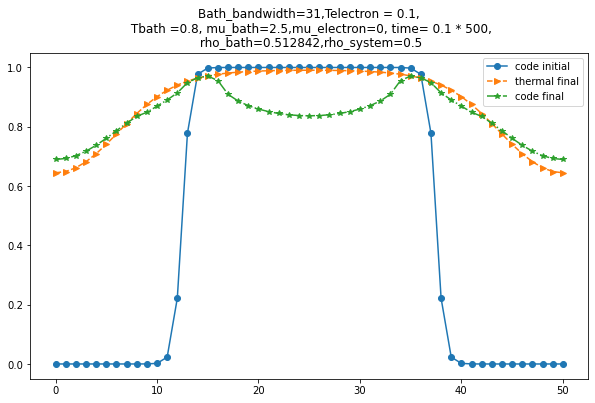

In [378]:
plt.figure(figsize=(10,6))


plt.plot(np.arange(51),np.real(occupations[:,0]),'-o',label='code initial')
plt.plot(np.arange(51),newoccu,'-->',label='thermal final')
plt.plot(np.arange(51),np.real(occupations[:,499]),'-.*',label='code final')


# plt.plot(energy_electron(np.arange(51)),np.real(occupations[:,0]),'-o',label='code initial')
# plt.plot(energy_electron(np.arange(51)),newoccu,'-->',label='thermal final')
# plt.plot(energy_electron(np.arange(51)),np.real(occupations[:,499]),'-.*',label='code final')
plt.title("Bath_bandwidth=%g,Telectron = %g,\n Tbath =%g, mu_bath=%g,mu_electron=%g, time= %g * %g,\n rho_bath=%g,rho_system=%g"%(bandwidth,Temp_electron,Temp_bath,mu_bath,mu_electron,h,testrange,rho_bath[0],rho_system[0]))
plt.legend()
#plt.savefig("fig5Oct9")

In [379]:
# occupations.shape

In [380]:
# len(occupations[1:,499])

In [381]:
# testing=np.arange(0,100,10)

In [382]:
# for i in testing:
#     print(integrate.quad(s1,-pie/a1,pie/a1,args=(Temp_bath,mu_bath,i)))

In [383]:
# print(integrate.quad(s1,-pie/a1,pie/a1,args=(Temp_bath,mu_bath,30)))

### Density Comparison

In [384]:
# # density comparison

# s1 = lambda k,T,mu,te:1/(np.exp((-2*te*(np.cos(k*a1))-mu)*(1/T))+1)*(1/(2*pie))

In [385]:
# rho_system = integrate.quad(s1,-pie/a1,pie/a1,args=(Temp_electron,mu_electron,t_electron))
# rho_system
# #telectron = 1

In [386]:
# rho_bath = integrate.quad(s1,-pie/a1,pie/a1,args=(Temp_bath,mu_bath,32))
# rho_bath

In [387]:
# lst = [8,12,16,18,20,25,28,32,40,50,80,100,200,1000]
# # lst=np.array(lst)
# # integrate.quad(s1,-pie,pie,args=(Temp_bath,20,lst))

# for i in lst:
#     print(i,integrate.quad(s1,-pie,pie,args=(Temp_bath,20,i)))

In [388]:
# Temp_electro = 0.1
# t_electron= 2
# Temp_bath= 0.8
# tb = 8
# mu_bath= 2.5
# mu_electro = 0

# def energyelectron(k,t):
#     return -2*t*(np.cos(V_ph[k]*a1))

# def quadtest(x,en,tB):
#     return (1/pie)*(1*fermi(x,Temp_bath,mu_bath))*(Lambda**2)*(J(x,tB))*( 1/( (x-en)**2 + (Lambda**2*J(x,tB))**2 ) )


# def newres(e,hop):  # computes n(E) i.e. equilibrium occupation at energy E using bath spectral function
#     return integrate.quad(quadtest, -2*hop,2*hop,args=(e,hop))


# rho_system = integrate.quad(s1,-pie/a1,pie/a1,args=(Temp_electro,mu_electro,t_electron))
# print("rho_system = ",rho_system)
# rho_bath = integrate.quad(s1,-pie/a1,pie/a1,args=(Temp_bath,mu_bath,tb))
# print("rho_bath = ",rho_bath)


# lst=[]# initial distribution
# lst2=[] #final thermal distribution
# lst3=[] #fermi distribution at initial temperature

# for i in range(sitenum):
#     lst3.append(fermi(energyelectron(i,t_electron),Temp_electro,mu_electro))
#     lst2.append(newres(energyelectron(i,t_electron),tb)[0])
#     lst.append((1+np.imag(Gkeldysh(i,0,0,Temp_electro,mu_electro)))*0.5)    #np.imag(Gkeldysh(i,1,1,Temp_electron,mu_electron))
    
# plt.figure(figsize=(10,6))
# plt.plot(energyelectron(np.arange(50),t_electron),lst,'o',label='code intial')
# plt.axvline(x=mu_electro,label='μ electron')
# plt.axvline(x=mu_bath,color='green',label='μ bath')
# plt.plot(energyelectron(np.arange(50),t_electron),lst2,'->',label='thermal final')
# plt.plot(energyelectron(np.arange(50),t_electron),lst3,'*',label='fermi intial')
# plt.legend()


In [389]:
import quadpy
# @njit
# def sigmak(w,tB):
#     return -complex(0,1)*(Lambda**2)*J(w,tB)*np.tanh((w-mu_bath)/(2*Temp_bath))
# #=lambda w,tB: -complex(0,1)*(Lambda**2)*J(w,tB)*np.tanh((w-mu_bath)/(2*Temp_bath))


def SigmaK2(t1,t2,tB):
    newfunc = lambda w,t1,t2,tB: sigmak(w,tB)*np.exp(-complex(0,1)*w*(t1-t2)*h)/(2*pie)
    result = quadpy.quad(newfunc,-2*tB,2*tB,args=(t1,t2,tB))
    return result

In [390]:
SigmaK2(1,0,32)

((-0.11422039560324464+0.04868120457381132j), 5.6690987911124e-09)

In [391]:
SigmaK(1,0,32)

(-0.11422027128345782+0.048681206822211984j)

In [463]:
def sp1(ω,k):
    sum=0
    for i in range(testrange):
        sum = sum + Grmatrix[k][i,1]*np.exp(complex(0,1)*ω*(i)*h)*h
    return np.imag(sum)*(-1/pie)

def sp2(ω,k):
    sum=0
    for i in range(testrange):
        sum = sum + Grmatrix[k][i,1]*np.exp(complex(0,1)*ω*(i-1)*h)*h
    return np.real(sum)*(-1/pie)




(-68.2, 68.2)

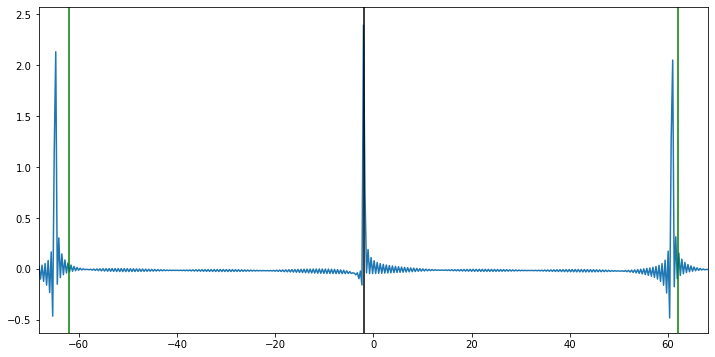

In [482]:
modeofinterest= 25
omval = np.linspace(-5*bandwidth,5*bandwidth,1000)
plt.figure(figsize=(12,6))
plt.plot(omval,sp1(omval,modeofinterest))#,title="Plot of Im[Gʳ(ϵ,ω)] vs ω")
plt.axvline(x=2*bandwidth,color='green')
plt.axvline(x=-2*bandwidth,color='green')
plt.axvline(x=energy_electron(modeofinterest),color='black')
#plt.plot(omval,sp2(omval,modeofinterest),'-*')
plt.xlim(-2.2*bandwidth,2.2*bandwidth)

#plt.title("Plot of Im[Gʳ(ϵ,ω)] vs ω for bandbottom mode")



In [501]:
def A(x,en):
    if abs(x)<=2*bandwidth:
        return (1/pie)*(Lambda**2)*(J(x,bandwidth))*(1/((x-en)**2 + (Lambda**2*J(x,bandwidth))**2))
    else:
        return 0


In [502]:
A(1,2)

0.020448359626344528

(-68.2, 68.2)

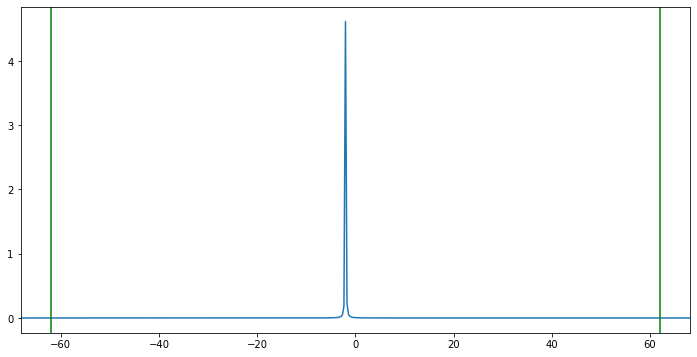

In [510]:
moi= 25
omval = np.linspace(-5*bandwidth,5*bandwidth,1000)
listy=[]
for i in omval:
    #print(i)
    listy.append(A(i,energy_electron(moi)))
    
plt.figure(figsize=(12,6))

plt.plot(omval,listy)#,title="Plot of Im[Gʳ(ϵ,ω)] vs ω")

plt.axvline(x=2*bandwidth,color='green')
plt.axvline(x=-2*bandwidth,color='green')
#plt.axvline(x=energy_electron(modeofinterest),color='black')

plt.xlim(-2.2*bandwidth,2.2*bandwidth)

In [493]:
bandwidth

31

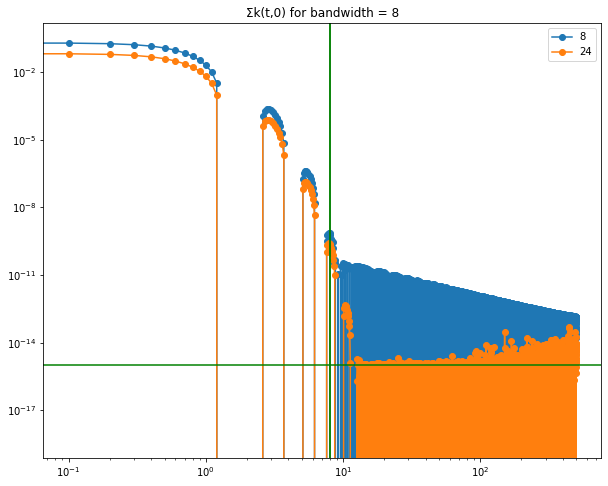

In [613]:
lst=np.arange(0,5000)
bandwidth=8
bandwidth2=24
bandwidth3=80
lst2 = [SigmaK(i,0,bandwidth)for i in lst]
lst3= [SigmaK(i,0,bandwidth2)for i in lst]
lst4= [SigmaK(i,0,bandwidth3)for i in lst]
plt.figure(figsize=(10,8))
#plt.plot(lst,np.real(lst2),'-o',label='real')
plt.plot(lst*h,np.imag(lst2),'-o',label='%g'%(bandwidth))
plt.plot(lst*h,np.imag(lst3),'-o',label='%g'%bandwidth2)
# plt.plot(lst*h,np.imag(lst4),'-o',label='%g'%bandwidth3)
plt.axvline(x=bandwidth,color='green')
plt.axvline(x=bandwidth,color='green')
plt.axhline(y=1e-15,color='green')
plt.yscale("log")
plt.xscale("log")
# plt.ylim(0,)
# plt.xlim(1e2,)
#plt.ylim(,0.025)

plt.title("Σk(t,0) for bandwidth = %g"%bandwidth)
plt.legend()

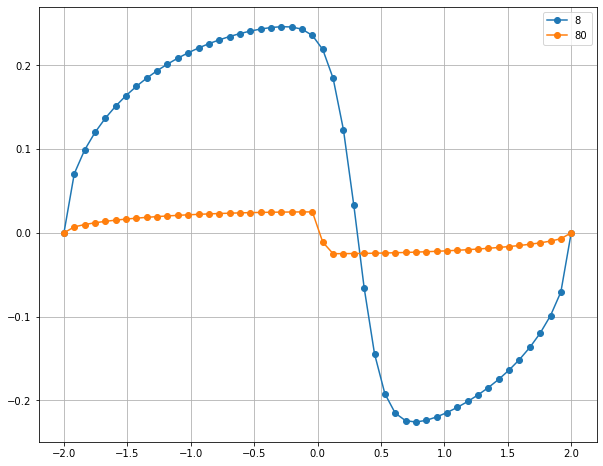

In [603]:
bandwidth=8
bandwidth2=80
plt.figure(figsize=(10,8))
omval=np.linspace(-2,2)
#plt.plot(omval,np.real(sigmak(omval,bandwidth)))
plt.plot(omval,np.imag(sigmak(omval*bandwidth,bandwidth)),'-o',label="%g"%bandwidth)
plt.plot(omval,np.imag(sigmak(omval*bandwidth2,bandwidth2)),'-o',label="%g"%bandwidth2)
plt.grid()
plt.legend()

In [612]:
np.finfo(float)

finfo(resolution=1e-15, min=-1.7976931348623157e+308, max=1.7976931348623157e+308, dtype=float64)